## Read PDF Page 12

In [1]:
import fitz
print(fitz.__doc__)


PyMuPDF 1.21.1: Python bindings for the MuPDF 1.21.1 library.
Version date: 2022-12-13 00:00:01.
Built for Python 3.9 on win32 (64-bit).



In [2]:
filename = "../keppel-corporation-limited-annual-report-2018.pdf"
doc = fitz.open(filename)

In [3]:
print("number of pages: ",doc.page_count)
print("metadata: ",doc.metadata)
print("table of contents: ",doc.get_toc())

number of pages:  230
metadata:  {'format': 'PDF 1.6', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': 'Adobe InDesign CC 2017 (Macintosh)', 'producer': 'Adobe PDF Library 15.0', 'creationDate': "D:20190314111838+08'00'", 'modDate': "D:20190314114440+08'00'", 'trapped': '', 'encryption': None}
table of contents:  []


In [4]:
page = doc.load_page(11)
page.get_text()

'While pursuing new markets and opportunities, \nwe are growing our stable and recurring income \nfrom the quality operations and maintenance \nservices provided by Infrastructure Services. \nKeppel Electric has been the largest electricity \nretailer in Singapore in terms of market share in \nthe commercial and industrial sector. Following \nthe launch of the Open Electricity Market (OEM) \nin Singapore, Keppel Electric is also making \nheadway into the housing electricity market. \nStarting from 1 November 2018, the OEM is \nbeing progressively extended to all consumers \nacross Singapore by zones. The response to \nKeppel Electric’s retail offerings for households \nhas been encouraging, with preliminary \nresults showing that it is among the retailers \nwith the largest market shares in the OEM. \nKeppel T&T is scaling up its logistics and \ndata centre solutions to tap opportunities \ncreated by the fast-growing digital economy. \nWith the burgeoning growth of cloud service \nprov

## Pass page to OpenCV

In [5]:
import numpy as np
import cv2
# Visualization
import matplotlib.pyplot as plt

In [6]:
zoom = 1
mat = fitz.Matrix(zoom, zoom)
pix = page.get_pixmap(matrix = mat)
imgData = pix.save('./page_12.png')

Text(0.5, 1.0, 'Original Image')

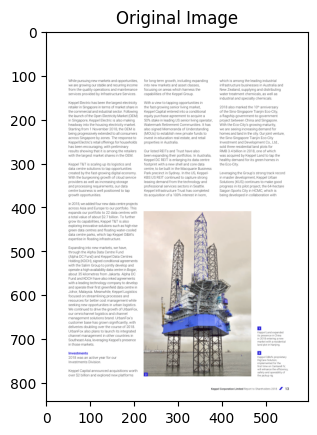

In [7]:
img = cv2.imread("./page_12.png")
plt.imshow(img)
plt.title('Original Image')

Text(0.5, 1.0, 'Binary Inverse Mask')

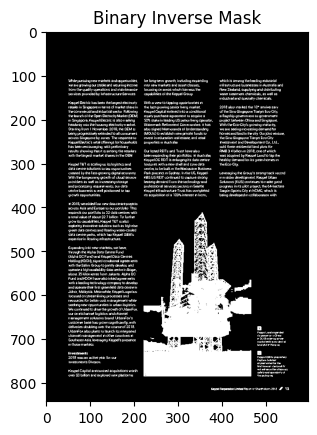

In [8]:
# Binary Inverse Mask
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# cv2.imwrite('./page_12_gray.png',gray)
ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
plt.imshow(thresh1, cmap='Greys_r')
plt.title('Binary Inverse Mask')

### Detect Content Section

Text(0.5, 1.0, 'Dilated Image for Section Detection')

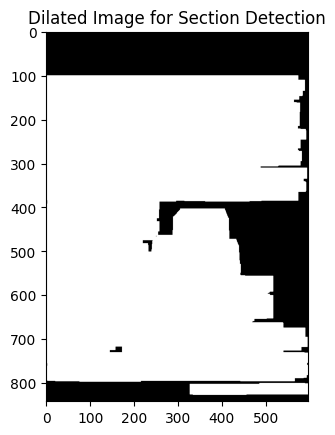

In [9]:
rect_kernel_section = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 20))
# # cv2.imwrite('./page_12_rect_kernel.png',rect_kernel)
dilation_section = cv2.dilate(thresh1, rect_kernel_section, iterations = 1)
# cv2.imwrite('./page_12_dilation.png',dilation)
plt.imshow(dilation_section, cmap='Greys_r')
plt.title('Dilated Image for Section Detection')

Sections found:  2
(2, 101, 596, 798)
(327, 801, 596, 828)


Text(0.5, 1.0, 'Contents Section Identified')

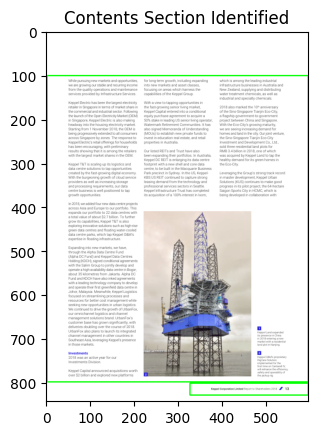

In [10]:
contours_section, hierarchy_section = cv2.findContours(dilation_section, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
print("Sections found: ",len(contours_section))
img_section=img.copy()
sections = []
for cnt in contours_section:
    x, y, w, h = cv2.boundingRect(cnt)
    # Drawing a rectangle on copied image
    rect = cv2.rectangle(img_section, (x, y), (x + w, y + h), (0, 255, 0), 2)
    sections.append((x,y,x + w, y + h))
sections.sort(key = lambda r:(r[0],r[1]))
for sect in sections:
    print(sect)
plt.imshow(img_section)
plt.title('Contents Section Identified')

Content: Section 0
Footer: Section 1

### Detecting Paragraphs

Text(0.5, 1.0, 'Dilated Image for Paragraph Detection')

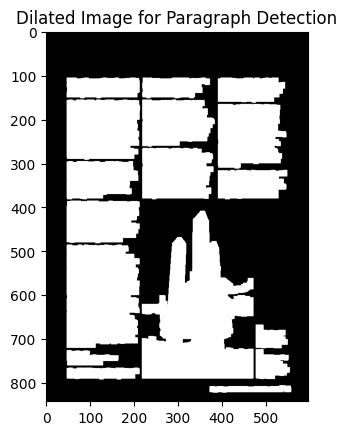

In [11]:
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
# cv2.imwrite('./page_12_rect_kernel.png',rect_kernel)
dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)
plt.imshow(dilation, cmap='Greys_r')
plt.title('Dilated Image for Paragraph Detection')

Contours found:  17
Out of bound:  (372, 806) (558, 823)
Paragraphs found:  16
(47, 106, 213, 153)
(47, 156, 214, 293)
(47, 296, 210, 383)
(47, 386, 213, 483)
(47, 486, 213, 721)
(47, 726, 165, 761)
(47, 766, 213, 793)
(218, 409, 472, 791)
(219, 106, 373, 153)
(219, 156, 384, 263)
(219, 266, 381, 383)
(391, 106, 544, 163)
(391, 166, 547, 313)
(391, 316, 549, 383)
(477, 668, 550, 722)
(477, 724, 555, 792)


Text(0.5, 1.0, 'Paragraphs Identified')

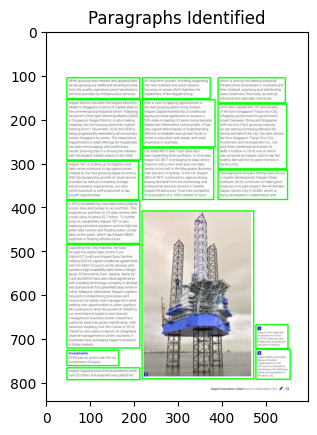

In [12]:
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
print("Contours found: ",len(contours))
# print(hierarchy)
im2=img.copy()
rects = []
contents_box = sections[0]
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if x < contents_box[0] or y < contents_box[1] or (x+w) > contents_box[2] or (y+h) > contents_box[3]:
        print('Out of bound: ',(x,y),(x+w,y+h))
        continue
    # Drawing a rectangle on copied image
    rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 2)
    rects.append((x,y,x + w, y + h))

rects.sort(key = lambda r:(r[0],r[1]))
print('Paragraphs found: ',len(rects))
for rect in rects:
    print(rect)
plt.imshow(im2)
plt.title('Paragraphs Identified')

## Get text from rectangles

In [13]:
paragraphs = []
i = 1
prev_x = None
prev_y = None
for rect in rects:
    para = page.get_textbox(fitz.Rect(*rect))
    print('paragraph {}'.format(i))
    print(para)
    print('-'*20)
    paragraphs.append({
        'text': para,
        'new_column': (rect[0] > prev_x and rect[1] < prev_y) if (prev_x and prev_y) else True
    })
    prev_x, prev_y = rect[0],rect[1]
    i+=1

paragraph 1
While pursuing new markets and opportunities, 
we are growing our stable and recurring income 
from the quality operations and maintenance 
services provided by Infrastructure Services. 
--------------------
paragraph 2
Keppel Electric has been the largest electricity 
retailer in Singapore in terms of market share in 
the commercial and industrial sector. Following 
the launch of the Open Electricity Market (OEM) 
in Singapore, Keppel Electric is also making 
headway into the housing electricity market. 
Starting from 1 November 2018, the OEM is 
being progressively extended to all consumers 
across Singapore by zones. The response to 
Keppel Electric’s retail offerings for households 
has been encouraging, with preliminary 
results showing that it is among the retailers 
with the largest market shares in the OEM. 
--------------------
paragraph 3
Keppel T&T is scaling up its logistics and 
data centre solutions to tap opportunities 
created by the fast-growing digital eco

In [14]:
[p for p in paragraphs if p['new_column']]

[{'text': 'While pursuing new markets and opportunities, \nwe are growing our stable and recurring income \nfrom the quality operations and maintenance \nservices provided by Infrastructure Services. ',
  'new_column': True},
 {'text': '2', 'new_column': True},
 {'text': 'for long-term growth, including expanding \ninto new markets and asset classes, \nfocusing on areas which harness the \ncapabilities of the Keppel Group. ',
  'new_column': True},
 {'text': 'which is among the leading industrial \ninfrastructure businesses in Australia and \nNew Zealand, supplying and distributing \nwater treatment chemicals, as well as \nindustrial and specialty chemicals. ',
  'new_column': True}]

## Cleaning noise and joining paragraphs

In [15]:
# Remove paragraphs with less than 2 words.
def is_noise(p):
    return len(p['text'].split(' ')) < 2
paragraphs = [p for p in paragraphs if not is_noise(p)]
print('Number of paragraphs: ', len(paragraphs))

Number of paragraphs:  15


In [16]:
# Defining punctuations for EOS (End of Sentence)
eos_flags = ['.','!','?']
final_paragraphs = []
tmp = None
for p in paragraphs:
    txt = p['text']
    txt = txt.replace('\n','').strip()
    if p['new_column'] and tmp is not None:
        tmp = tmp + ' ' + txt
        final_paragraphs.append(tmp)
        tmp = None
    elif txt[-1] not in eos_flags:
        print('Unfinished: ')
        print(txt)
        print('-' * 20)
        tmp = txt
    else:
        final_paragraphs.append(txt)
        
if tmp:
    final_paragraphs.append(tmp)
print('No. of final paragraphs: ', len(final_paragraphs))
        

Unfinished: 
Keppel Capital announced acquisitions worth over $2 billion and explored new platforms
--------------------
Unfinished: 
Our listed REITs and Trust have also been expanding their portfolios. In Australia, Keppel DC REIT is enlarging its data centre footprint with a new shell and core data centre, to be built in the Macquarie Business Park precinct in Sydney. In the US, Keppel-KBS US REIT continued to capture strong leasing demand from the technology and professional services sectors in Seattle. Keppel Infrastructure Trust has completed its acquisition of a 100% interest in Ixom,
--------------------
Unfinished: 
Leveraging the Group’s strong track record in master development, Keppel Urban Solutions (KUS) continues to make good progress in its pilot project, the 64-hectare Saigon Sports City in HCMC, which is being developed in collaboration with
--------------------
No. of final paragraphs:  13


## Convert into Pandas Dataframe and sava to excel

In [17]:
import pandas as pd

In [18]:
df = pd.DataFrame(final_paragraphs,columns=['Text'])
df['No. '] = df.apply(lambda row: 'Paragraph {}'.format(row.name + 1),axis=1)
df = df[['No. ', 'Text']]
df

,No.,Text
0,Paragraph 1,"While pursuing new markets and opportunities, ..."
1,Paragraph 2,Keppel Electric has been the largest electrici...
2,Paragraph 3,Keppel T&T is scaling up its logistics and dat...
3,Paragraph 4,"In 2018, we added four new data centre project..."
4,Paragraph 5,"Expanding into new markets, we have, through t..."
5,Paragraph 6,Investments 2018 was an active year for our In...
6,Paragraph 7,Keppel Capital announced acquisitions worth ov...
7,Paragraph 8,With a view to tapping opportunities in the fa...
8,Paragraph 9,Our listed REITs and Trust have also been expa...
9,Paragraph 10,2018 also marked the 10th anniversary of the S...


In [19]:
df.to_excel('Assignment 1 Output.xlsx', index=False)